# Dynamic Pricing for Urban Parking Lots
# Notebook 3: Pricing Model Development

This notebook implements three pricing models from scratch:
1. Model 1: Baseline Linear Model
2. Model 2: Demand-Based Price Function
3. Model 3: Competitive Pricing Model 

All models built using only NumPy and Pandas

# 1. IMPORT LIBRARIES

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import json
from datetime import datetime
import warnings
warnings.filterwarnings('ignore')

print("Libraries imported successfully!")


Libraries imported successfully!


# 2. LOAD DATA AND ARTIFACTS

In [4]:
# Load featured dataset
data = pd.read_csv('featured_data.csv')
data['DateTime'] = pd.to_datetime(data['DateTime'])

In [6]:
# Load proximity artifacts
distance_matrix = np.load('distance_matrix.npy')
parking_lots = pd.read_csv('parking_lot_info.csv')

with open('competitor_map.json', 'r') as f:
    competitor_map = json.load(f)
    # Convert string keys back to integers
    competitor_map = {int(k): v for k, v in competitor_map.items()}

print(f"Dataset loaded: {data.shape}")
print(f"Distance matrix shape: {distance_matrix.shape}")
print(f"Number of parking lots: {len(parking_lots)}")

Dataset loaded: (18368, 36)
Distance matrix shape: (14, 14)
Number of parking lots: 14


# 3. INITIALIZE BASE PRICE

In [7]:
BASE_PRICE = 10.0  # Starting price as per requirement

print(f"\n{'='*70}")
print(f"BASE PRICE INITIALIZATION")
print(f"{'='*70}")
print(f"Base Price: ${BASE_PRICE}")

# Initialize price column
data['CurrentPrice'] = BASE_PRICE


BASE PRICE INITIALIZATION
Base Price: $10.0


# 4. MODEL 1: BASELINE LINEAR MODEL

In [10]:
print(f"\n{'='*70}")
print(f"MODEL 1: BASELINE LINEAR PRICING MODEL")
print(f"{'='*70}")

class BaselineLinearPricing:
    """
    Simple linear model where price adjusts based on occupancy rate.
    
    Formula: Price_t+1 = Price_t + α * (Occupancy / Capacity)
    
    This provides a baseline for comparison.
    """
    
    def __init__(self, base_price=10.0, alpha=2.0, max_price=20.0, min_price=5.0):
        """
        Parameters:
        - base_price: Starting price ($)
        - alpha: Price adjustment coefficient
        - max_price: Maximum allowed price
        - min_price: Minimum allowed price
        """
        self.base_price = base_price
        self.alpha = alpha
        self.max_price = max_price
        self.min_price = min_price
        self.prices = {}  # Store last price for each lot
        
    def initialize_prices(self, lot_ids):
        """Initialize all parking lots with base price"""
        for lot_id in lot_ids:
            self.prices[lot_id] = self.base_price
    
    def calculate_price(self, lot_id, occupancy_rate, previous_price=None):
        """
        Calculate new price based on occupancy
        
        Parameters:
        - lot_id: Parking lot identifier
        - occupancy_rate: Current occupancy percentage (0-100)
        - previous_price: Last recorded price
        
        Returns:
        - new_price: Adjusted price
        """
        if previous_price is None:
            previous_price = self.prices.get(lot_id, self.base_price)
        
        # Linear adjustment based on occupancy
        adjustment = self.alpha * (occupancy_rate / 100)
        
        new_price = previous_price + adjustment
        
        # Apply bounds
        new_price = np.clip(new_price, self.min_price, self.max_price)
        
        # Store price
        self.prices[lot_id] = new_price
        
        return new_price

    
# Initialize Model 1
model1 = BaselineLinearPricing(base_price=BASE_PRICE, alpha=2.0)
model1.initialize_prices(data['LotID'].unique())

# Apply Model 1 to dataset
print("\nApplying Baseline Linear Model...")

model1_prices = []
data_sorted = data.sort_values(['LotID', 'DateTime']).reset_index(drop=True)

for idx, row in data_sorted.iterrows():
    if idx > 0 and data_sorted.loc[idx-1, 'LotID'] == row['LotID']:
        prev_price = model1_prices[-1]
    else:
        prev_price = BASE_PRICE
    
    price = model1.calculate_price(
        lot_id=row['LotID'],
        occupancy_rate=row['OccupancyRate'],
        previous_price=prev_price
    )
    model1_prices.append(price)

data_sorted['Model1_Price'] = model1_prices

print(f"✓ Model 1 applied successfully")
print(f"\nModel 1 Price Statistics:")
print(data_sorted['Model1_Price'].describe())


MODEL 1: BASELINE LINEAR PRICING MODEL

Applying Baseline Linear Model...
✓ Model 1 applied successfully

Model 1 Price Statistics:
count    18368.000000
mean        19.955891
std          0.556105
min         10.139137
25%         20.000000
50%         20.000000
75%         20.000000
max         20.000000
Name: Model1_Price, dtype: float64


# 5. MODEL 2: DEMAND-BASED PRICE FUNCTION

In [11]:
print(f"\n{'='*70}")
print(f"MODEL 2: DEMAND-BASED PRICING MODEL")
print(f"{'='*70}")

class DemandBasedPricing:
    """
    Advanced pricing model incorporating multiple demand factors.
    
    Demand Function combines:
    - Occupancy rate (primary factor)
    - Queue length (urgency indicator)
    - Traffic condition (external demand)
    - Special day (event-based surge)
    - Vehicle type (differential pricing)
    
    Price is then adjusted based on normalized demand with smoothing.
    """
    
    def __init__(self, base_price=10.0, 
                 alpha=0.5, beta=0.2, gamma=0.15, delta=0.1, epsilon=0.05,
                 price_multiplier=0.8, max_multiplier=2.0, min_multiplier=0.5):
        """
        Parameters:
        - base_price: Starting price
        - alpha, beta, gamma, delta, epsilon: Demand function weights
        - price_multiplier: How aggressively price responds to demand
        - max/min_multiplier: Price bounds as multiples of base price
        """
        self.base_price = base_price
        self.alpha = alpha
        self.beta = beta
        self.gamma = gamma
        self.delta = delta
        self.epsilon = epsilon
        self.price_multiplier = price_multiplier
        self.max_price = base_price * max_multiplier
        self.min_price = base_price * min_multiplier
    
    def calculate_demand_score(self, occupancy_rate, queue_length, 
                               traffic_level, is_special_day, vehicle_weight):
        """
        Calculate composite demand score
        
        Returns:
        - demand_score: Normalized demand indicator (0 to ~1)
        """
        # Normalize inputs
        occupancy_norm = occupancy_rate / 100  # 0 to 1
        queue_norm = np.minimum(queue_length / 10, 1)  # Cap at 10
        traffic_norm = (traffic_level - 1) / 2  # Map 1,2,3 to 0,0.5,1
        
        # Calculate weighted demand score
        demand = (
            self.alpha * occupancy_norm +
            self.beta * queue_norm +
            self.gamma * traffic_norm +
            self.delta * is_special_day +
            self.epsilon * (vehicle_weight - 0.5) / 1.0  # Normalize vehicle weight
        )
        
        return demand
    
    def calculate_price(self, occupancy_rate, queue_length, traffic_level,
                       is_special_day, vehicle_weight, hour, is_peak_hour):
        """
        Calculate price based on demand factors
        
        Returns:
        - price: Dynamic price based on current conditions
        """
        # Calculate base demand
        demand_score = self.calculate_demand_score(
            occupancy_rate, queue_length, traffic_level,
            is_special_day, vehicle_weight
        )
        
        # Add time-based adjustment (peak hour premium)
        time_adjustment = 0.1 if is_peak_hour else 0
        demand_score += time_adjustment
        
        # Apply non-linear transformation for smoother pricing
        # Using sigmoid-like curve for gradual price increase
        normalized_demand = np.tanh(demand_score)  # Smooth between -1 and 1
        
        # Calculate price
        price = self.base_price * (1 + self.price_multiplier * normalized_demand)
        
        # Apply bounds
        price = np.clip(price, self.min_price, self.max_price)
        
        return price

# Initialize Model 2
model2 = DemandBasedPricing(
    base_price=BASE_PRICE,
    alpha=0.50,      # Occupancy weight (highest)
    beta=0.20,       # Queue weight
    gamma=0.15,      # Traffic weight
    delta=0.10,      # Special day weight
    epsilon=0.05,    # Vehicle type weight
    price_multiplier=0.8,
    max_multiplier=2.0,
    min_multiplier=0.5
)

# Apply Model 2 to dataset
print("\nApplying Demand-Based Pricing Model...")

model2_prices = []

for idx, row in data_sorted.iterrows():
    price = model2.calculate_price(
        occupancy_rate=row['OccupancyRate'],
        queue_length=row['QueueLength'],
        traffic_level=row['TrafficLevel_Encoded'],
        is_special_day=row['IsSpecialDay'],
        vehicle_weight=row['VehicleWeight'],
        hour=row['Hour'],
        is_peak_hour=row['IsPeakHour']
    )
    model2_prices.append(price)

data_sorted['Model2_Price'] = model2_prices

print(f"✓ Model 2 applied successfully")
print(f"\nModel 2 Price Statistics:")
print(data_sorted['Model2_Price'].describe())


MODEL 2: DEMAND-BASED PRICING MODEL

Applying Demand-Based Pricing Model...
✓ Model 2 applied successfully

Model 2 Price Statistics:
count    18368.000000
mean        13.848454
std          1.107392
min         10.248447
25%         13.040625
50%         13.894142
75%         14.720771
max         16.458825
Name: Model2_Price, dtype: float64


# 6. MODEL 3: COMPETITIVE PRICING MODEL

In [12]:
print(f"\n{'='*70}")
print(f"MODEL 3: COMPETITIVE PRICING MODEL (OPTIONAL)")
print(f"{'='*70}")

class CompetitivePricing:
    """
    Sophisticated pricing model that considers competitor prices and suggests routing.
    
    Features:
    - Monitors nearby competitor prices
    - Adjusts price based on competitive positioning
    - Suggests rerouting when beneficial
    - Incorporates location-based strategy
    """
    
    def __init__(self, base_price=10.0, demand_model=None, 
                 competitor_weight=0.2, distance_matrix=None, competitor_map=None):
        """
        Parameters:
        - base_price: Starting price
        - demand_model: Instance of DemandBasedPricing for base calculation
        - competitor_weight: How much competitor prices influence our price
        - distance_matrix: Matrix of distances between lots
        - competitor_map: Dictionary of nearby competitors
        """
        self.base_price = base_price
        self.demand_model = demand_model if demand_model else DemandBasedPricing(base_price)
        self.competitor_weight = competitor_weight
        self.distance_matrix = distance_matrix
        self.competitor_map = competitor_map
        self.current_prices = {}  # Track all lot prices
    
    def update_market_prices(self, lot_id, price):
        """Store current price for a parking lot"""
        self.current_prices[lot_id] = price
    
    def get_competitor_prices(self, lot_id):
        """Get prices of nearby competitors"""
        if lot_id not in self.competitor_map or not self.competitor_map[lot_id]:
            return []
        
        competitor_prices = []
        for competitor_id in self.competitor_map[lot_id]:
            if competitor_id in self.current_prices:
                distance = self.distance_matrix[lot_id][competitor_id]
                competitor_prices.append({
                    'lot_id': competitor_id,
                    'price': self.current_prices[competitor_id],
                    'distance': distance
                })
        
        return competitor_prices
    
    def calculate_price(self, lot_id, occupancy_rate, queue_length, traffic_level,
                       is_special_day, vehicle_weight, hour, is_peak_hour, capacity, occupancy):
        """
        Calculate competitive price considering market conditions
        
        Returns:
        - price: Dynamically adjusted price
        - routing_suggestion: Alternative lot if current is overburdened
        """
        # Start with demand-based price
        base_demand_price = self.demand_model.calculate_price(
            occupancy_rate, queue_length, traffic_level,
            is_special_day, vehicle_weight, hour, is_peak_hour
        )
        
        # Get competitor information
        competitors = self.get_competitor_prices(lot_id)
        
        routing_suggestion = None
        final_price = base_demand_price
        
        if competitors:
            # Calculate average competitor price (weighted by distance)
            total_weight = 0
            weighted_price_sum = 0
            
            for comp in competitors:
                weight = 1 / (comp['distance'] + 0.1)  # Closer = more weight
                weighted_price_sum += comp['price'] * weight
                total_weight += weight
            
            avg_competitor_price = weighted_price_sum / total_weight if total_weight > 0 else base_demand_price
            
            # Competitive adjustment
            if occupancy_rate >= 85:
                # Near full: check if we should suggest rerouting
                cheaper_alternatives = [c for c in competitors if c['price'] < base_demand_price * 0.9]
                
                if cheaper_alternatives:
                    # Suggest routing to nearest cheaper alternative
                    best_alternative = min(cheaper_alternatives, key=lambda x: x['distance'])
                    routing_suggestion = best_alternative['lot_id']
                    
                    # Reduce our price slightly to remain competitive
                    final_price = base_demand_price * 0.95
                else:
                    # We can charge premium if no cheaper alternatives
                    final_price = base_demand_price * 1.05
            
            else:
                # Not full: price competitively based on market
                price_gap = base_demand_price - avg_competitor_price
                
                if price_gap > 2:  # We're much more expensive
                    # Adjust down towards market
                    final_price = base_demand_price - self.competitor_weight * price_gap
                elif price_gap < -2:  # We're much cheaper
                    # We can increase price
                    final_price = base_demand_price + self.competitor_weight * abs(price_gap)
                else:
                    # Price is competitive
                    final_price = base_demand_price
        
        # Apply bounds
        final_price = np.clip(final_price, self.base_price * 0.5, self.base_price * 2.0)
        
        # Store our price for competitors to see
        self.update_market_prices(lot_id, final_price)
        
        return final_price, routing_suggestion

# Initialize Model 3
model3 = CompetitivePricing(
    base_price=BASE_PRICE,
    demand_model=model2,  # Use Model 2 as base
    competitor_weight=0.2,
    distance_matrix=distance_matrix,
    competitor_map=competitor_map
)

# Apply Model 3 to dataset
print("\nApplying Competitive Pricing Model...")

model3_prices = []
routing_suggestions = []

for idx, row in data_sorted.iterrows():
    price, routing = model3.calculate_price(
        lot_id=row['LotID'],
        occupancy_rate=row['OccupancyRate'],
        queue_length=row['QueueLength'],
        traffic_level=row['TrafficLevel_Encoded'],
        is_special_day=row['IsSpecialDay'],
        vehicle_weight=row['VehicleWeight'],
        hour=row['Hour'],
        is_peak_hour=row['IsPeakHour'],
        capacity=row['Capacity'],
        occupancy=row['Occupancy']
    )
    model3_prices.append(price)
    routing_suggestions.append(routing)

data_sorted['Model3_Price'] = model3_prices
data_sorted['Routing_Suggestion'] = routing_suggestions

print(f"✓ Model 3 applied successfully")
print(f"\nModel 3 Price Statistics:")
print(data_sorted['Model3_Price'].describe())

routing_count = data_sorted['Routing_Suggestion'].notna().sum()
print(f"\nRouting suggestions made: {routing_count} times ({routing_count/len(data_sorted)*100:.2f}%)")



MODEL 3: COMPETITIVE PRICING MODEL (OPTIONAL)

Applying Competitive Pricing Model...
✓ Model 3 applied successfully

Model 3 Price Statistics:
count    18368.000000
mean        13.768681
std          1.008710
min         10.248447
25%         13.040625
50%         13.864186
75%         14.575863
max         16.225609
Name: Model3_Price, dtype: float64

Routing suggestions made: 1631 times (8.88%)


# 7. MODEL COMPARISON

In [13]:
print(f"\n{'='*70}")
print(f"MODEL COMPARISON & EVALUATION")
print(f"{'='*70}")

# Calculate summary statistics
comparison_stats = pd.DataFrame({
    'Model 1 (Linear)': data_sorted['Model1_Price'].describe(),
    'Model 2 (Demand)': data_sorted['Model2_Price'].describe(),
    'Model 3 (Competitive)': data_sorted['Model3_Price'].describe()
})

print("\nPrice Statistics Across Models:")
print(comparison_stats.round(2))

# Calculate price volatility (standard deviation)
volatility = {
    'Model 1': data_sorted['Model1_Price'].std(),
    'Model 2': data_sorted['Model2_Price'].std(),
    'Model 3': data_sorted['Model3_Price'].std()
}

print(f"\nPrice Volatility (Standard Deviation):")
for model, vol in volatility.items():
    print(f"  {model}: ${vol:.2f}")


MODEL COMPARISON & EVALUATION

Price Statistics Across Models:
       Model 1 (Linear)  Model 2 (Demand)  Model 3 (Competitive)
count          18368.00          18368.00               18368.00
mean              19.96             13.85                  13.77
std                0.56              1.11                   1.01
min               10.14             10.25                  10.25
25%               20.00             13.04                  13.04
50%               20.00             13.89                  13.86
75%               20.00             14.72                  14.58
max               20.00             16.46                  16.23

Price Volatility (Standard Deviation):
  Model 1: $0.56
  Model 2: $1.11
  Model 3: $1.01


# 8. VISUALIZATIONS


GENERATING MODEL COMPARISON VISUALIZATIONS


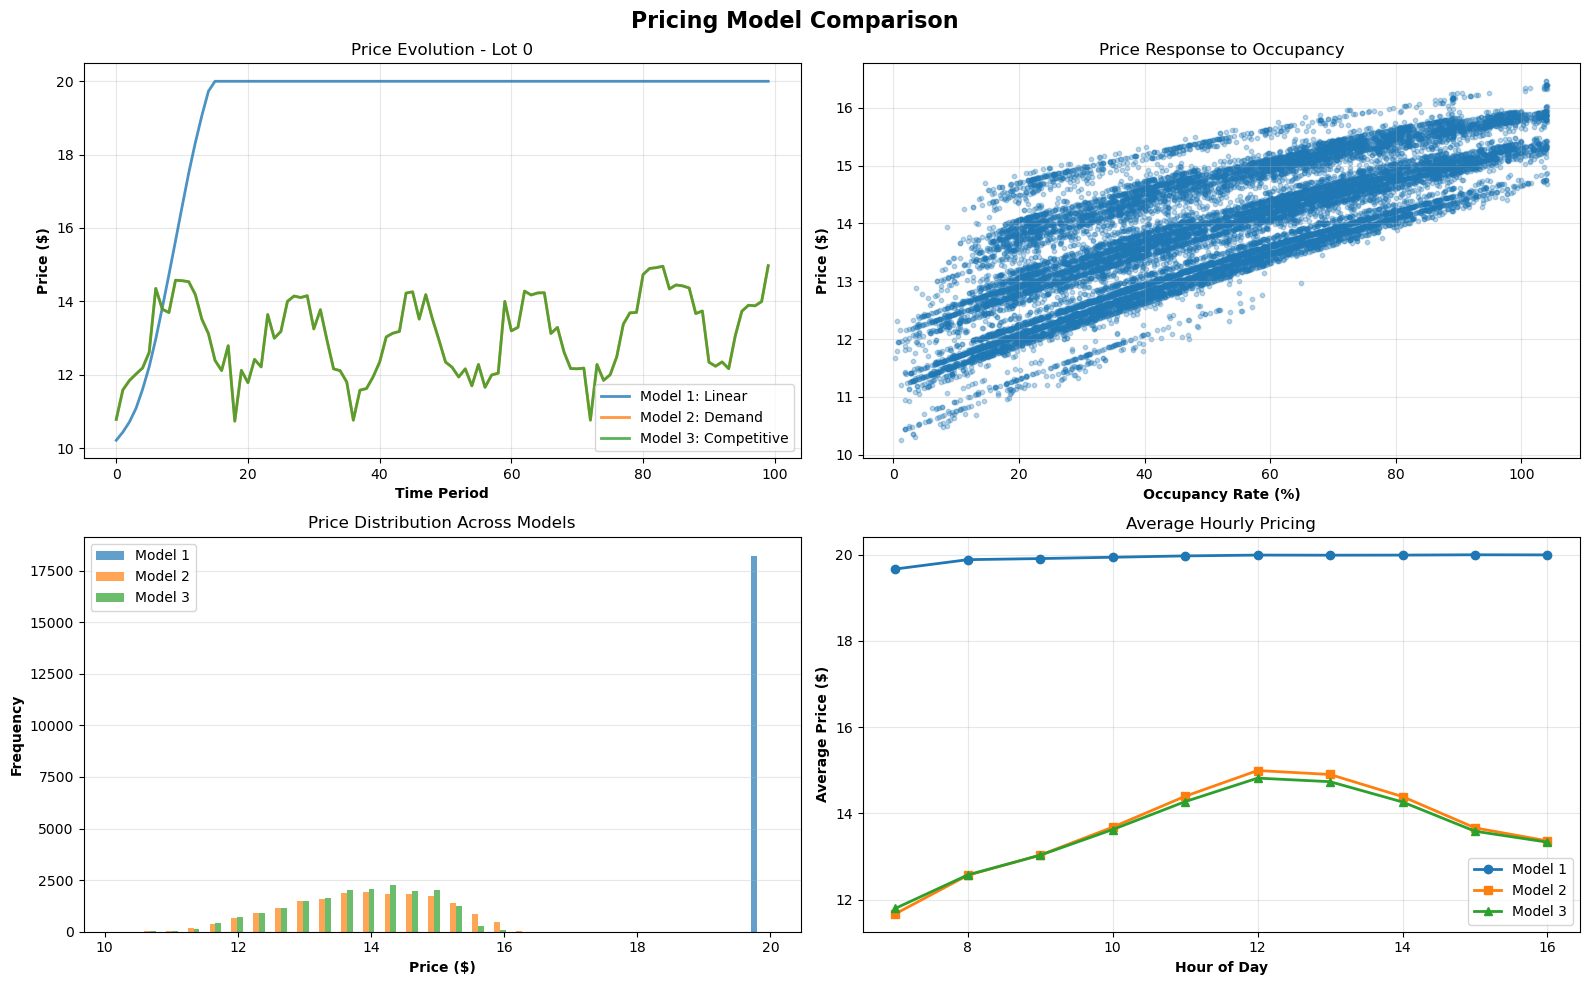

✓ Model comparison visualization saved


In [14]:
print(f"\n{'='*70}")
print(f"GENERATING MODEL COMPARISON VISUALIZATIONS")
print(f"{'='*70}")

# Select a sample parking lot for detailed visualization
sample_lot = data_sorted['LotID'].mode()[0]
sample_data = data_sorted[data_sorted['LotID'] == sample_lot].head(100)

# Figure 1: Price Comparison Over Time
fig, axes = plt.subplots(2, 2, figsize=(16, 10))
fig.suptitle('Pricing Model Comparison', fontsize=16, fontweight='bold')

# Plot 1: All models over time
axes[0, 0].plot(sample_data.index, sample_data['Model1_Price'], 
                label='Model 1: Linear', linewidth=2, alpha=0.8)
axes[0, 0].plot(sample_data.index, sample_data['Model2_Price'], 
                label='Model 2: Demand', linewidth=2, alpha=0.8)
axes[0, 0].plot(sample_data.index, sample_data['Model3_Price'], 
                label='Model 3: Competitive', linewidth=2, alpha=0.8)
axes[0, 0].set_xlabel('Time Period', fontweight='bold')
axes[0, 0].set_ylabel('Price ($)', fontweight='bold')
axes[0, 0].set_title(f'Price Evolution - Lot {sample_lot}')
axes[0, 0].legend()
axes[0, 0].grid(True, alpha=0.3)

# Plot 2: Price vs Occupancy Rate
axes[0, 1].scatter(data_sorted['OccupancyRate'], data_sorted['Model2_Price'], 
                   alpha=0.3, s=10, label='Model 2')
axes[0, 1].set_xlabel('Occupancy Rate (%)', fontweight='bold')
axes[0, 1].set_ylabel('Price ($)', fontweight='bold')
axes[0, 1].set_title('Price Response to Occupancy')
axes[0, 1].grid(True, alpha=0.3)

# Plot 3: Price Distribution
axes[1, 0].hist([data_sorted['Model1_Price'], data_sorted['Model2_Price'], 
                 data_sorted['Model3_Price']], bins=30, label=['Model 1', 'Model 2', 'Model 3'],
                alpha=0.7)
axes[1, 0].set_xlabel('Price ($)', fontweight='bold')
axes[1, 0].set_ylabel('Frequency', fontweight='bold')
axes[1, 0].set_title('Price Distribution Across Models')
axes[1, 0].legend()
axes[1, 0].grid(True, alpha=0.3, axis='y')

# Plot 4: Average price by hour
hourly_prices = data_sorted.groupby('Hour')[['Model1_Price', 'Model2_Price', 'Model3_Price']].mean()
axes[1, 1].plot(hourly_prices.index, hourly_prices['Model1_Price'], 
                marker='o', label='Model 1', linewidth=2)
axes[1, 1].plot(hourly_prices.index, hourly_prices['Model2_Price'], 
                marker='s', label='Model 2', linewidth=2)
axes[1, 1].plot(hourly_prices.index, hourly_prices['Model3_Price'], 
                marker='^', label='Model 3', linewidth=2)
axes[1, 1].set_xlabel('Hour of Day', fontweight='bold')
axes[1, 1].set_ylabel('Average Price ($)', fontweight='bold')
axes[1, 1].set_title('Average Hourly Pricing')
axes[1, 1].legend()
axes[1, 1].grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('figures/07_model_comparison.png', dpi=300, bbox_inches='tight')
plt.show()

print("✓ Model comparison visualization saved")

# 9. BUSINESS METRICS CALCULATION

In [15]:
print(f"\n{'='*70}")
print(f"BUSINESS IMPACT ANALYSIS")
print(f"{'='*70}")

def calculate_revenue(prices, occupancies):
    """Calculate total revenue"""
    return (prices * occupancies).sum()

def calculate_utilization(occupancies, capacities):
    """Calculate average utilization rate"""
    return (occupancies / capacities).mean() * 100

# Calculate metrics for each model
for model_name, price_col in [('Model 1', 'Model1_Price'), 
                               ('Model 2', 'Model2_Price'), 
                               ('Model 3', 'Model3_Price')]:
    revenue = calculate_revenue(data_sorted[price_col], data_sorted['Occupancy'])
    utilization = calculate_utilization(data_sorted['Occupancy'], data_sorted['Capacity'])
    
    print(f"\n{model_name}:")
    print(f"  Total Revenue: ${revenue:,.2f}")
    print(f"  Avg Utilization: {utilization:.2f}%")
    print(f"  Avg Price: ${data_sorted[price_col].mean():.2f}")


BUSINESS IMPACT ANALYSIS

Model 1:
  Total Revenue: $268,065,279.88
  Avg Utilization: 50.91%
  Avg Price: $19.96

Model 2:
  Total Revenue: $189,806,560.80
  Avg Utilization: 50.91%
  Avg Price: $13.85

Model 3:
  Total Revenue: $188,599,315.12
  Avg Utilization: 50.91%
  Avg Price: $13.77


# 10. SAVE RESULTS

In [16]:
# Save final dataset with all model prices
output_data = data_sorted[[
    'ID', 'SystemCodeNumber', 'LotID', 'DateTime', 'Capacity', 
    'Occupancy', 'OccupancyRate', 'QueueLength', 'VehicleType',
    'TrafficConditionNearby', 'IsSpecialDay', 'Hour',
    'Model1_Price', 'Model2_Price', 'Model3_Price', 'Routing_Suggestion'
]]

output_data.to_csv('pricing_results.csv', index=False)

print(f"\n✓ Pricing results saved to 'pricing_results.csv'")


✓ Pricing results saved to 'pricing_results.csv'
